## Imports

In [1]:
import glob
import os
import cv2
import random
import torch
import torchvision

import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from torch import nn
from typing import Tuple, Any
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2
import torchvision.models as models

In [2]:
os.environ["KMP_DUPLICATE_LIB_OK"] = (
    "True"  # A fix for some strange matplotlib error
)

## Set seed

In [3]:
seed = 44

In [4]:
seed = 44
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

## Load data

In [5]:
def load_data(dataset_folder_path: str) -> Tuple[pd.DataFrame, torch.tensor]:
    """
    Returns pd.Dataframe with targets and torch.tensor with photo data
    """
    df = None
    photos = []
    curr_photo_id = 0
    for csv_file in glob.glob(f"{dataset_folder_path}/*.csv"):
        folder_df = pd.read_csv(
            csv_file, header=None, names=["filename", "forward", "left"]
        )
        photo_folder_name = os.path.splitext(csv_file)[0]
        folder_df["folder_name"] = photo_folder_name
        photo_paths = glob.glob(f"{photo_folder_name}/*.jpg")
        for photo_path in photo_paths:
            photos.append(torchvision.io.read_image(photo_path))
        folder_df["photo_id"] = folder_df.index + curr_photo_id
        curr_photo_id += folder_df.index.max() + 1
        if df is None:
            df = folder_df
        else:
            df = pd.concat([df, folder_df], axis=0)
    df = df.set_index("photo_id")
    photos = torch.from_numpy(np.array(photos))
    return df, photos


df, photos = load_data("dataset")
df

,filename,forward,left,folder_name
photo_id,,,,
0,24,0.039062,0.000000,dataset\1652875851.3497071
1,25,0.210938,0.000000,dataset\1652875851.3497071
2,26,0.390625,0.000000,dataset\1652875851.3497071
3,27,0.421875,0.000000,dataset\1652875851.3497071
4,28,0.421875,0.000000,dataset\1652875851.3497071
...,...,...,...,...
7579,113,0.398438,0.992188,dataset\1653043549.5187616
7580,114,0.367188,0.992188,dataset\1653043549.5187616
7581,115,0.367188,0.992188,dataset\1653043549.5187616


## Dataset

In [6]:
class JetbotDataset(Dataset):
    def __init__(
        self,
        df: pd.DataFrame,
        images: torch.tensor,
        transforms: list | None = None,
    ) -> None:
        """
        df: pd.DataFrame loaded by load_data()
        images: torch.tensor with image data loaded by load_data()
        transforms: a list of transforms to augment the data with
        """
        super().__init__()
        if transforms is None:
            transforms = []
        self.df = df
        self.images = images
        self.transforms = transforms

    def __len__(self) -> int:
        return self.df.shape[0]

    def __getitem__(self, index) -> Tuple[np.array, np.array]:
        sample = self.df.iloc[index]
        target = torch.tensor([sample.forward, sample.left], dtype=torch.float32)
        img = self.images[index].float()
        if len(self.transforms) > 0:
            random_transform = np.random.choice(self.transforms)
            img, target = random_transform(img, target)
            
        return img, target

In [7]:
def display_image(img: torch.tensor, target: torch.tensor = None):
    plt.imshow(img.numpy().astype(np.uint8).transpose((1, 2, 0)))
    if target is not None:
        plt.text(
            0,
            -10,
            f'Target: [{",".join([str(i) for i in target])}]',
            fontsize="x-large",
        )

## Transforms

In [8]:
class RandomJetbotHorizontalFlip(torch.nn.Module):
    def __init__(self, p: float = 0.5) -> None:
        super().__init__()
        self.p = p

    def forward(self, *inputs: Any) -> Any:
        img, target = inputs
        if np.random.random() >= self.p:  # Flip
            img = torchvision.transforms.functional.hflip(img)
            target[1] *= -1  # Flip 'left' component
        return img, target


# Vertical flip doesn't make sense in our problem

train_transforms = [RandomJetbotHorizontalFlip()]  # Feel free to add more
test_transforms = []  # Test on original examples

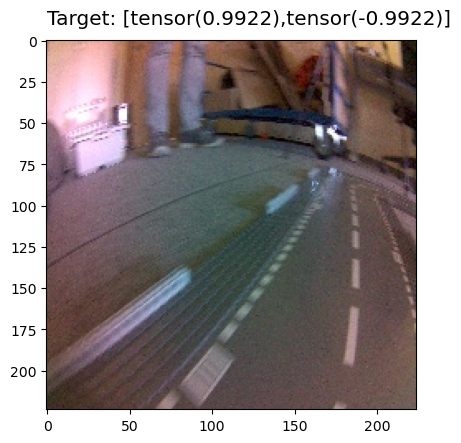

In [9]:
dataset = JetbotDataset(df, photos, train_transforms)
img, target = dataset[400]
display_image(img, target)

## Train-test-validation split

In [10]:
train_size = 0.7
val_size = 0.15
test_size = 1 - (train_size + val_size)
batch_size = 64

data_indices = np.random.permutation(np.arange(df.shape[0]))

train_end_index = int(len(data_indices) * train_size)
val_end_index = train_end_index + int(len(data_indices) * val_size)

train_dataloader = DataLoader(
    JetbotDataset(
        df.iloc[data_indices[:train_end_index]],
        photos[data_indices[:train_end_index]],
    ),
    batch_size=batch_size,
)

val_dataloader = DataLoader(
    JetbotDataset(
        df.iloc[data_indices[train_end_index:val_end_index]],
        photos[data_indices[train_end_index:val_end_index]],
    ),
    batch_size=batch_size,
)

test_dataloader = DataLoader(
    JetbotDataset(
        df.iloc[data_indices[val_end_index:]],
        photos[data_indices[val_end_index:]],
    ),
    batch_size=batch_size,
)

## Training / Evaluation functions.

In [11]:
def train_model(
    model: nn.Module,
    epochs: int,
    trainloader: DataLoader,
    validloader: DataLoader,
    optimizer: torch.optim.Optimizer,
    loss_func: callable,
    model_save_path: str,
    force_cuda: bool = False,
):
    """
    Taken from https://www.geeksforgeeks.org/training-neural-networks-with-validation-using-pytorch/,
    feel free to change it
    """
    if force_cuda and torch.cuda.is_available():
        model.cuda()

    min_valid_loss = np.inf
    for e in range(epochs):
        train_loss = 0.0
        model.train()  # Optional when not using Model Specific layer
        for data, labels in tqdm(trainloader):
            if force_cuda and torch.cuda.is_available():
                data, labels = data.cuda(), labels.cuda()

            optimizer.zero_grad()
            target = model(data)
            loss = loss_func(target, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        valid_loss = 0.0
        model.eval()  # Optional when not using Model Specific layer
        for data, labels in tqdm(validloader):
            if torch.cuda.is_available():
                data, labels = data.cuda(), labels.cuda()

            target = model(data)
            loss = loss_func(target, labels)
            valid_loss = loss.item() * data.size(0)

        print(
            f"Epoch {e+1} \t\t Training Loss: {train_loss / len(trainloader)} \t\t Validation Loss: {valid_loss / len(validloader)}"
        )
        
        if min_valid_loss > valid_loss:
            print(
                f"Validation Loss Decreased({min_valid_loss:.6f}--->{valid_loss:.6f}) \t Saving The Model"
            )
            min_valid_loss = valid_loss
            # Saving State Dict
            torch.save(model.state_dict(), model_save_path)

In [12]:
def evaluate_model(
    model: nn.Module,
    dataloader: DataLoader,
    loss_func: callable,
    device: torch.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
):
    model.to(device)
    model.eval()

    total_loss = 0.0
    total_samples = 0

    with torch.no_grad():
        for data, labels in dataloader:
            data, labels = data.to(device), labels.to(device)

            outputs = model(data)
            loss = loss_func(outputs, labels)
            
            total_loss += loss.item() * data.size(0)
            total_samples += data.size(0)

    avg_loss = total_loss / total_samples
    return avg_loss

## Model 1: Classical Convolution

In [15]:
class ClassicConv(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3, 10, kernel_size=(3, 3), padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)),
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(10, 50, kernel_size=(3, 3), padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)),
        )
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(50, 100, kernel_size=(3, 3), padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)),
        )
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))
        self.fully_connected = nn.Sequential(
            nn.Linear(100, 50),
            nn.ReLU(),
            nn.Linear(50, 10),
            nn.ReLU(),
            nn.Linear(10, 2),
            nn.Tanh(),
        )

    def forward(self, x: torch.Tensor):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.global_pool(x)
        x = x.flatten(1, -1)
        x = self.fully_connected(x)
        return x

In [16]:
conv_model = ClassicConv()
optimizer = torch.optim.Adam(conv_model.parameters())
loss = nn.MSELoss()
print(conv_model)
print(f"Total number of parameters = {sum(p.numel() for p in conv_model.parameters())}")

ClassicConv(
  (conv_block1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(10, 50, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block3): Sequential(
    (0): Conv2d(50, 100, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (global_pool): AdaptiveMaxPool2d(output_size=(1, 1))
  (fully_connected): Sequential(
    (0): Linear(in_features=100, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=2, bias=True)
    (5): Tanh()
  )
)
Total number of p

In [17]:
train_model(
    conv_model,
    epochs=15,
    trainloader=train_dataloader,
    validloader=val_dataloader,
    optimizer=optimizer,
    loss_func=loss,
    model_save_path='Model1.pth',
    force_cuda=True
)

100%|██████████| 18/18 [00:00<00:00, 29.20it/s]


Epoch 1 		 Training Loss: 0.26150349949497775 		 Validation Loss: 0.7002254145012962
Validation Loss Decreased(inf--->12.604057) 	 Saving The Model


100%|██████████| 18/18 [00:00<00:00, 29.22it/s]


Epoch 2 		 Training Loss: 0.2218208874923637 		 Validation Loss: 0.648463131652938
Validation Loss Decreased(12.604057--->11.672336) 	 Saving The Model


100%|██████████| 18/18 [00:00<00:00, 28.73it/s]


Epoch 3 		 Training Loss: 0.19569910542074456 		 Validation Loss: 0.547952166861958
Validation Loss Decreased(11.672336--->9.863139) 	 Saving The Model


100%|██████████| 18/18 [00:00<00:00, 28.58it/s]


Epoch 4 		 Training Loss: 0.1527744672564139 		 Validation Loss: 0.44286133348941803
Validation Loss Decreased(9.863139--->7.971504) 	 Saving The Model


100%|██████████| 18/18 [00:00<00:00, 27.40it/s]


Epoch 5 		 Training Loss: 0.13637336666684552 		 Validation Loss: 0.4256214367018806
Validation Loss Decreased(7.971504--->7.661186) 	 Saving The Model


100%|██████████| 18/18 [00:00<00:00, 19.70it/s]


Epoch 6 		 Training Loss: 0.12769769868218755 		 Validation Loss: 0.38306549936532974
Validation Loss Decreased(7.661186--->6.895179) 	 Saving The Model


100%|██████████| 18/18 [00:00<00:00, 18.33it/s]


Epoch 7 		 Training Loss: 0.12276483874723136 		 Validation Loss: 0.34853195812967086
Validation Loss Decreased(6.895179--->6.273575) 	 Saving The Model


100%|██████████| 18/18 [00:00<00:00, 29.75it/s]


Epoch 8 		 Training Loss: 0.12016896966351084 		 Validation Loss: 0.3337058383557532
Validation Loss Decreased(6.273575--->6.006705) 	 Saving The Model


100%|██████████| 18/18 [00:00<00:00, 29.20it/s]


Epoch 9 		 Training Loss: 0.11590295590191002 		 Validation Loss: 0.3054840573006206
Validation Loss Decreased(6.006705--->5.498713) 	 Saving The Model


100%|██████████| 18/18 [00:00<00:00, 28.31it/s]


Epoch 10 		 Training Loss: 0.11356181400008948 		 Validation Loss: 0.40289542492893005


100%|██████████| 18/18 [00:00<00:00, 29.07it/s]


Epoch 11 		 Training Loss: 0.11082525416670075 		 Validation Loss: 0.3498844926555951


100%|██████████| 18/18 [00:00<00:00, 28.07it/s]


Epoch 12 		 Training Loss: 0.10548435609383755 		 Validation Loss: 0.3165588337514136


100%|██████████| 18/18 [00:00<00:00, 29.12it/s]


Epoch 13 		 Training Loss: 0.1014767934579447 		 Validation Loss: 0.33201102250152165


100%|██████████| 18/18 [00:00<00:00, 29.10it/s]


Epoch 14 		 Training Loss: 0.10155126237007508 		 Validation Loss: 0.32319476331273717


100%|██████████| 18/18 [00:00<00:00, 29.26it/s]

Epoch 15 		 Training Loss: 0.0987774483769773 		 Validation Loss: 0.3149549629953172


In [18]:
conv_model.load_state_dict(torch.load('Model1.pth'))

avg_loss = evaluate_model(conv_model, test_dataloader, nn.MSELoss())
print(f'Test Loss: {avg_loss:.4f}')

Test Loss: 0.1190


## Model 2: deeper conv model

In [19]:
class DeepConv(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=(3, 3), padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)),
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=(3, 3), padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)),
        )
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=(3, 3), padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)),
        )
        self.conv_block4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=(3, 3), padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)),
        )
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))
        self.fully_connected = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 2),
            nn.Tanh(),
        )

    def forward(self, x: torch.Tensor):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.conv_block4(x)
        x = self.global_pool(x)
        x = x.flatten(1, -1)
        x = self.fully_connected(x)
        return x

In [20]:
deep_conv_model = DeepConv()
optimizer = torch.optim.Adam(deep_conv_model.parameters())
loss = nn.MSELoss()
print(deep_conv_model)
print(f"Total number of parameters = {sum(p.numel() for p in deep_conv_model.parameters())}")

DeepConv(
  (conv_block1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (global_pool): AdaptiveMaxPool2d(output_size=(1, 1))
  (fully_connected): Sequential(
    (0): Linear(in_features=128, out_f

In [21]:
train_model(
    deep_conv_model,
    epochs=15,
    trainloader=train_dataloader,
    validloader=val_dataloader,
    optimizer=optimizer,
    loss_func=loss,
    model_save_path='Model2.pth',
    force_cuda=True
)

100%|██████████| 18/18 [00:00<00:00, 29.35it/s]


Epoch 1 		 Training Loss: 0.25413583685834723 		 Validation Loss: 0.6493860905369123
Validation Loss Decreased(inf--->11.688950) 	 Saving The Model


100%|██████████| 18/18 [00:00<00:00, 30.25it/s]


Epoch 2 		 Training Loss: 0.1767296982278307 		 Validation Loss: 0.39327191644244724
Validation Loss Decreased(11.688950--->7.078894) 	 Saving The Model


100%|██████████| 18/18 [00:00<00:00, 31.49it/s]


Epoch 3 		 Training Loss: 0.12531981015779886 		 Validation Loss: 0.3738057307071156
Validation Loss Decreased(7.078894--->6.728503) 	 Saving The Model


100%|██████████| 18/18 [00:00<00:00, 31.20it/s]


Epoch 4 		 Training Loss: 0.11532025568815599 		 Validation Loss: 0.30771016370919013
Validation Loss Decreased(6.728503--->5.538783) 	 Saving The Model


100%|██████████| 18/18 [00:00<00:00, 29.71it/s]


Epoch 5 		 Training Loss: 0.10911615507071276 		 Validation Loss: 0.27328965481784606
Validation Loss Decreased(5.538783--->4.919214) 	 Saving The Model


100%|██████████| 18/18 [00:00<00:00, 31.02it/s]


Epoch 6 		 Training Loss: 0.10296057900750494 		 Validation Loss: 0.32119524892833495


100%|██████████| 18/18 [00:00<00:00, 31.39it/s]


Epoch 7 		 Training Loss: 0.09560019926852491 		 Validation Loss: 0.27168706183632213
Validation Loss Decreased(4.919214--->4.890367) 	 Saving The Model


100%|██████████| 18/18 [00:00<00:00, 30.51it/s]


Epoch 8 		 Training Loss: 0.0934775173664093 		 Validation Loss: 0.29711153068476254


100%|██████████| 18/18 [00:00<00:00, 30.63it/s]


Epoch 9 		 Training Loss: 0.09032329127012965 		 Validation Loss: 0.2835535920328564


100%|██████████| 18/18 [00:00<00:00, 30.31it/s]


Epoch 10 		 Training Loss: 0.0864739810756172 		 Validation Loss: 0.24746867020924887
Validation Loss Decreased(4.890367--->4.454436) 	 Saving The Model


100%|██████████| 18/18 [00:00<00:00, 31.17it/s]


Epoch 11 		 Training Loss: 0.08488718168922217 		 Validation Loss: 0.3144434272415108


100%|██████████| 18/18 [00:00<00:00, 30.55it/s]


Epoch 12 		 Training Loss: 0.08169865680028157 		 Validation Loss: 0.21614889428019524
Validation Loss Decreased(4.454436--->3.890680) 	 Saving The Model


100%|██████████| 18/18 [00:00<00:00, 31.26it/s]


Epoch 13 		 Training Loss: 0.0745619283203619 		 Validation Loss: 0.20402177919944128
Validation Loss Decreased(3.890680--->3.672392) 	 Saving The Model


100%|██████████| 18/18 [00:00<00:00, 30.76it/s]


Epoch 14 		 Training Loss: 0.07528954448111086 		 Validation Loss: 0.1991588936911689
Validation Loss Decreased(3.672392--->3.584860) 	 Saving The Model


100%|██████████| 18/18 [00:00<00:00, 30.80it/s]

Epoch 15 		 Training Loss: 0.07177885581391404 		 Validation Loss: 0.2034044721060329


In [22]:
deep_conv_model.load_state_dict(torch.load('Model2.pth'))

avg_loss = evaluate_model(deep_conv_model, test_dataloader, nn.MSELoss())
print(f'Test Loss: {avg_loss:.4f}')

Test Loss: 0.1027


## Model 3: Resnet alike

In [23]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.skip = nn.Conv2d(in_channels, out_channels, kernel_size=1) if in_channels != out_channels else None

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        if self.skip:
            identity = self.skip(identity)

        out += identity
        out = self.relu(out)
        return out

class ResNetLike(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=(3, 3), padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)),
        )
        self.res_block1 = ResidualBlock(16, 32)
        self.res_block2 = ResidualBlock(32, 64)
        self.res_block3 = ResidualBlock(64, 128)
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))
        self.fully_connected = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 2),
            nn.Tanh(),
        )

    def forward(self, x: torch.Tensor):
        x = self.conv_block1(x)
        x = self.res_block1(x)
        x = self.res_block2(x)
        x = self.res_block3(x)
        x = self.global_pool(x)
        x = x.flatten(1, -1)
        x = self.fully_connected(x)
        return x

In [24]:
resnetlike_model = ResNetLike()
optimizer = torch.optim.Adam(resnetlike_model.parameters())
loss = nn.MSELoss()
print(resnetlike_model)
print(f"Total number of parameters = {sum(p.numel() for p in resnetlike_model.parameters())}")

ResNetLike(
  (conv_block1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (res_block1): ResidualBlock(
    (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (skip): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1))
  )
  (res_block2): ResidualBlock(
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1

In [25]:
train_model(
    resnetlike_model,
    epochs=15,
    trainloader=train_dataloader,
    validloader=val_dataloader,
    optimizer=optimizer,
    loss_func=loss,
    model_save_path='Model3.pth',
    force_cuda=True
)

100%|██████████| 18/18 [00:03<00:00,  5.55it/s]


Epoch 1 		 Training Loss: 0.24507014686802783 		 Validation Loss: 0.6421665830744637
Validation Loss Decreased(inf--->11.558998) 	 Saving The Model


100%|██████████| 18/18 [00:02<00:00,  6.52it/s]


Epoch 2 		 Training Loss: 0.19646584942757364 		 Validation Loss: 0.4473227138320605
Validation Loss Decreased(11.558998--->8.051809) 	 Saving The Model


100%|██████████| 18/18 [00:02<00:00,  6.59it/s]


Epoch 3 		 Training Loss: 0.1350345976920013 		 Validation Loss: 0.34822115467654335
Validation Loss Decreased(8.051809--->6.267981) 	 Saving The Model


100%|██████████| 18/18 [00:02<00:00,  6.71it/s]


Epoch 4 		 Training Loss: 0.11377634099089956 		 Validation Loss: 0.34038324488533866
Validation Loss Decreased(6.267981--->6.126898) 	 Saving The Model


100%|██████████| 18/18 [00:02<00:00,  6.64it/s]


Epoch 5 		 Training Loss: 0.10633038065160613 		 Validation Loss: 0.2813343409862783
Validation Loss Decreased(6.126898--->5.064018) 	 Saving The Model


100%|██████████| 18/18 [00:02<00:00,  6.60it/s]


Epoch 6 		 Training Loss: 0.10066938687519855 		 Validation Loss: 0.2705252605179946
Validation Loss Decreased(5.064018--->4.869455) 	 Saving The Model


100%|██████████| 18/18 [00:02<00:00,  6.59it/s]


Epoch 7 		 Training Loss: 0.09636040373020861 		 Validation Loss: 0.3701676022675302


100%|██████████| 18/18 [00:02<00:00,  6.65it/s]


Epoch 8 		 Training Loss: 0.08751585859670696 		 Validation Loss: 0.35116397092739743


100%|██████████| 18/18 [00:02<00:00,  6.67it/s]


Epoch 9 		 Training Loss: 0.08129758921911917 		 Validation Loss: 0.4232813244064649


100%|██████████| 18/18 [00:02<00:00,  6.61it/s]


Epoch 10 		 Training Loss: 0.07589217854371991 		 Validation Loss: 0.5590106364753511


100%|██████████| 18/18 [00:02<00:00,  6.66it/s]


Epoch 11 		 Training Loss: 0.08172755661499069 		 Validation Loss: 0.32597382159696686


100%|██████████| 18/18 [00:02<00:00,  6.63it/s]


Epoch 12 		 Training Loss: 0.07802554668791323 		 Validation Loss: 0.3521321184105343


100%|██████████| 18/18 [00:02<00:00,  6.66it/s]


Epoch 13 		 Training Loss: 0.06590507709118257 		 Validation Loss: 0.30421346260441673


100%|██████████| 18/18 [00:02<00:00,  6.51it/s]


Epoch 14 		 Training Loss: 0.061720463234078454 		 Validation Loss: 0.2628064677119255
Validation Loss Decreased(4.869455--->4.730516) 	 Saving The Model


100%|██████████| 18/18 [00:02<00:00,  6.62it/s]

Epoch 15 		 Training Loss: 0.07037991141698446 		 Validation Loss: 0.26193652633163667
Validation Loss Decreased(4.730516--->4.714857) 	 Saving The Model


In [26]:
resnetlike_model.load_state_dict(torch.load('Model3.pth'))

avg_loss = evaluate_model(resnetlike_model, test_dataloader, nn.MSELoss())
print(f'Test Loss: {avg_loss:.4f}')

Test Loss: 0.1143
